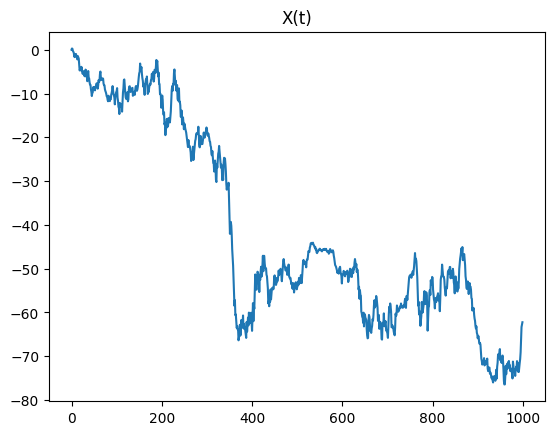

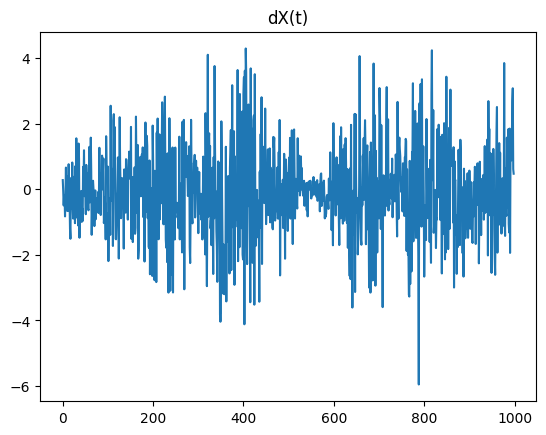

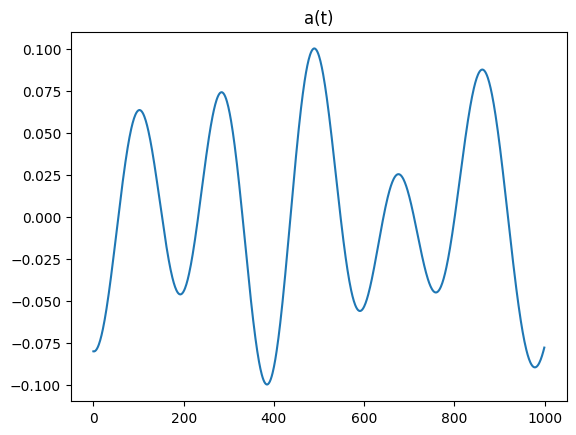

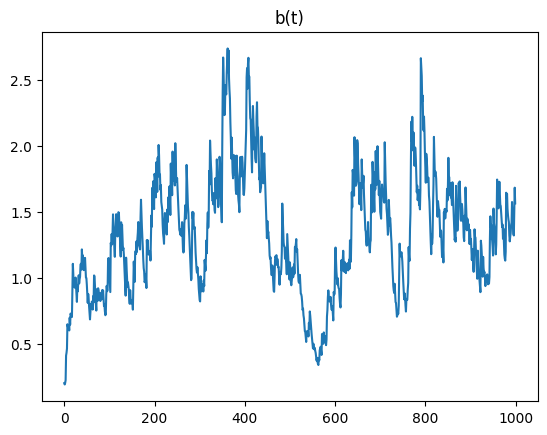

In [1]:
from sem.generate_series import create_sde_process
from sem.sem.mixture_sem import MixtureSEM
from sem.sem.mixture_em_diff import NormalMixtureEM
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
import torch
import numpy as np
import random

seed = 45
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(seed)



num_components = 5
length = 1000

series_dct = create_sde_process(length, n_components=num_components)
series = series_dct['X']
deltas = series[1:] - series[:-1]
a_trafaret = series_dct['a_t']
b_trafaret = series_dct['b_t']
plt.plot(series)
plt.title('X(t)')
plt.show()
plt.plot(deltas)
plt.title('dX(t)')
plt.show()
plt.plot(a_trafaret)
plt.title('a(t)')
plt.show()
plt.plot(b_trafaret)
plt.title('b(t)')
plt.show()

In [45]:
sem = MixtureSEM(deltas, 'exp', n_components=2, N_init=5, alpha=0.8, comp_distr='laplace', exp_smooth=0.8, prior_strength=1.0, tol=1e-4, device="cuda")
args = sem.find_params()

g = args['g']
a_k = args['mu']
b_k = args['sigma']
p_k = args['w']
nu = None
if 'nu' in args:
    nu = args['nu']

p_values = torch.tensor([0.5], dtype=torch.float32, device=g.device)

median = sem.batched_mixture_multiple_percentiles(p_k, p_values, g=g, mu=a_k, sigma=b_k, nu=nu).squeeze().cpu()

mode = sem.batched_mixture_mode(g=g, w=p_k, mu=a_k, sigma=b_k, nu=nu).squeeze().cpu()

a_k = args['mu'].squeeze().cpu()
b_k = args['sigma'].squeeze().cpu()
p_k = args['w'].squeeze().cpu()

mean = torch.sum((p_k * a_k), 1).cpu()

N = 5; Max ACF(1): 1.0
N = 10; Max ACF(1): 0.9496883153915405
N = 15; Max ACF(1): 0.9017770290374756
N = 20; Max ACF(1): 0.843960702419281
N = 25; Max ACF(1): 0.8277676701545715
N = 30; Max ACF(1): 0.7917792797088623
Found window length: 30


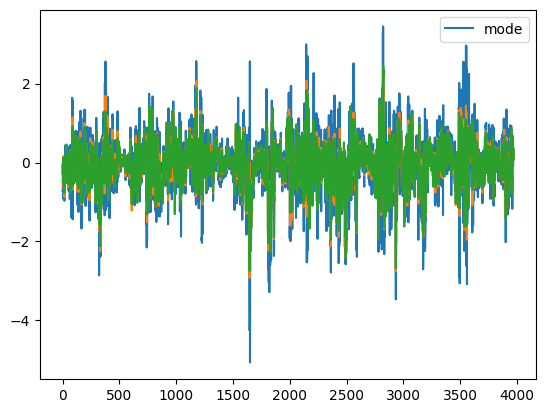

In [46]:
plt.plot(mode.cpu(), label='mode')
plt.plot(median.cpu())
plt.plot(mean)
plt.legend()
plt.show()
# На графике видно, что мода всегда перестреливает медиану

In [47]:
x_modal = torch.cumsum(mode, 0) + series[sem.series_length]
x_median = torch.cumsum(median, 0) + series[sem.series_length]
x_mean = torch.cumsum(torch.sum((p_k * a_k), 1), 0) + series[sem.series_length]

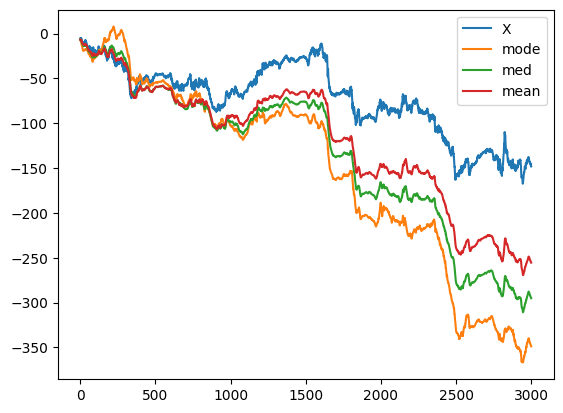

In [48]:
start = 0
finish = 3000
plt.plot(series[sem.series_length + start: sem.series_length + finish], label='X')
plt.plot(x_modal[start: finish], label='mode')
plt.plot(x_median[start: finish], label='med')
plt.plot(x_mean[start: finish], label='mean')
plt.legend()
plt.show()


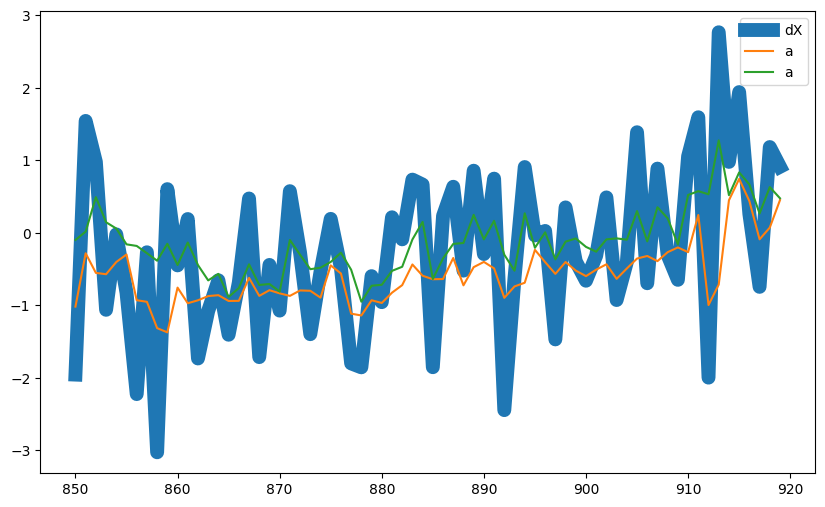

In [12]:
plt.figure(figsize=(10, 6))
start = 850
finish = 920
plt.plot(range(start, finish), deltas[sem.series_length-1 + start:sem.series_length-1 + finish], label='dX', linewidth=10)
plt.plot(range(start, finish), a_k[start:finish], label="a")
plt.legend()
plt.show()

In [13]:
p_k[start: finish], a_k[start: finish], mode[start: finish]

(tensor([[0.6659, 0.3341],
         [0.4017, 0.5983],
         [0.3295, 0.6705],
         [0.4577, 0.5423],
         [0.3736, 0.6264],
         [0.7641, 0.2359],
         [0.7492, 0.2508],
         [0.3630, 0.6370],
         [0.7583, 0.2417],
         [0.3860, 0.6140],
         [0.4747, 0.5253],
         [0.3222, 0.6778],
         [0.6317, 0.3683],
         [0.7740, 0.2260],
         [0.7237, 0.2763],
         [0.3790, 0.6210],
         [0.4973, 0.5027],
         [0.2815, 0.7185],
         [0.6698, 0.3302],
         [0.3030, 0.6970],
         [0.7099, 0.2901],
         [0.4944, 0.5056],
         [0.3201, 0.6799],
         [0.6075, 0.3925],
         [0.3794, 0.6206],
         [0.3882, 0.6118],
         [0.6381, 0.3619],
         [0.5052, 0.4948],
         [0.5395, 0.4605],
         [0.7658, 0.2342],
         [0.5455, 0.4545],
         [0.2600, 0.7400],
         [0.2334, 0.7666],
         [0.4670, 0.5330],
         [0.3639, 0.6361],
         [0.6951, 0.3049],
         [0.2264, 0.7736],
 

In [11]:
%matplotlib inline

window_size = 100

for i in range(0, 100000 - window_size, 4):
    clear_output(wait=True)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(i, i+window_size), deltas[sem.series_length-1 + i:sem.series_length-1 + i + window_size], label='X')
    plt.plot(range(i, i+window_size), a_k.cpu()[i:i+window_size], label="0.50 персентиль")
    plt.legend()
    plt.show()
    sleep(0.5)

KeyboardInterrupt: 